# Analyze associations between QTLs and GWAS colocalization

In [1]:
library(pheatmap)
library(colorspace)


In [2]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_gwas_coloc")

source("script/functions.R"  )


In [4]:
dir.create("pipeline/5.1.analyze_coloc_eqtls", showWarnings = FALSE)


In [5]:
manifest   = add_rownames(fread("pipeline/1.1.sumstats/manifest.txt"                     , sep = "\t", header = TRUE, data.table = FALSE))
loci       = add_rownames(fread("pipeline/1.2.genomewide_significant_loci/loci.txt"      , sep = "\t", header = TRUE, data.table = FALSE))
loci2study = add_rownames(fread("pipeline/1.2.genomewide_significant_loci/loci2study.txt", sep = "\t", header = TRUE, data.table = FALSE))
coloc_gwas =              fread("pipeline/2.1.coloc/coloc.txt"                           , sep = "\t", header = TRUE, data.table = FALSE)
coloc_qtls =              fread("pipeline/4.1.coloc_qtls/coloc_eqtls.txt"                , sep = "\t", header = TRUE, data.table = FALSE)

In [6]:
manifest    = manifest[ !manifest$description %in% c("K57 Diverticular disease of intestine", "Cataract", "M16 Coxarthrosis [arthrosis of hip]"), ]
loci2study  = loci2study[,rownames(manifest)]
loci2study  = loci2study[ rowSums(loci2study) > 0,]
loci        = loci[rownames(loci2study),]
loci$n_gwas = rowSums(loci2study)


In [7]:
qtl_list = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/qtl/qtls.RDS"   )
exp_list = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/expdata_qtl.rds")

In [16]:
phenotypes  = qtl_list$phenotypes
qtls        = qtl_list$qtl
coordinates = exp_list$coordinates
colordata   = exp_list$color
rownames(coordinates) = coordinates$transcript_id


In [9]:
populations = c('meta','AFR','AMR','CSA','EAS','EUR','MID')

In [39]:
qtl2gwas_df = aggregate(PP.H4.abf ~ transcript_id + gene_id + gene_name + type + phenotype + gwas + locus, data = coloc_qtls, FUN = max)

# Some numbers

In [10]:
message(paste("Loci that colocalize with QTLs"     , length(unique(coloc_qtls[ coloc_qtls$PP.H4.abf >= 0.9, "locus"        ])), sep = " = "))
message(paste("eElements that colocalize with GWAS", length(unique(coloc_qtls[ coloc_qtls$PP.H4.abf >= 0.9, "transcript_id"])), sep = " = "))

invisible(lapply(phenotypes$phenotype, function(phenotype){message(paste0("eElements (", phenotype, ") that colocalize with GWAS = ", length(unique(coloc_qtls[ coloc_qtls$PP.H4.abf >= 0.9 & coloc_qtls$phenotype == phenotype, "transcript_id"]))))}))

Loci that colocalize with QTLs = 511

eElements that colocalize with GWAS = 1427

eElements (rna) that colocalize with GWAS = 863

eElements (isoform) that colocalize with GWAS = 564

eElements (atac) that colocalize with GWAS = 0

eElements (chip) that colocalize with GWAS = 0



In [23]:
message(paste("Genes/transcripts tested for coloc with GWAS", length(unique(qtl2gwas_df$transcript_id)), sep = " = "))
message(paste("GWAS"                                        , length(unique(qtl2gwas_df$gwas         )), sep = " = "))
message(paste("Loci that include at least on eQTL"          , length(unique(qtl2gwas_df$locus        )), sep = " = "))


Genes/transcripts tested for coloc with GWAS = 11827

GWAS = 27

Loci that include at least on eQTL = 1530



# Calculate enrichment of cell type proportions at each GWAS

In [35]:
calculate_enrichment = function(gwas, phenotype, cell, qtl2gwas_df, qtl_list)
{
    x       = qtl2gwas_df[ qtl2gwas_df$gwas == gwas & qtl2gwas_df$phenotype == phenotype,]
    intdata = qtl_list[["interactions"]][[phenotype]]
    intdata = intdata[ intdata$interaction == cell,]
    return(x)
    x       = merge(x, intdata[, c("transcript_id", "type", "cell")], by = )
    return(x)
}

gwas = "biomarkers-30600-both_sexes-irnt"

x = calculate_enrichment(gwas, "rna", "ipsc_cvpc", qtl2gwas_df, qtl_list)

str(x)


'data.frame':	3022 obs. of  7 variables:
 $ transcript_id: chr  "ENSG00000260246.1_7" "ENSG00000241720.2_7" "ENSG00000181754.7_5" "ENSG00000162650.16_4" ...
 $ gene_id      : chr  "ENSG00000260246.1_7" "ENSG00000241720.2_7" "ENSG00000181754.7_5" "ENSG00000162650.16_4" ...
 $ gene_name    : chr  "AC000032.1" "AL158847.1" "AMIGO1" "ATXN7L2" ...
 $ phenotype    : chr  "rna" "rna" "rna" "rna" ...
 $ gwas         : chr  "biomarkers-30600-both_sexes-irnt" "biomarkers-30600-both_sexes-irnt" "biomarkers-30600-both_sexes-irnt" "biomarkers-30600-both_sexes-irnt" ...
 $ locus        : chr  "1_108920060_110727340" "1_108920060_110727340" "1_108920060_110727340" "1_108920060_110727340" ...
 $ PP.H4.abf    : num  0.443 0.274 0.104 0.913 0.11 ...


In [38]:
intdata = qtl_list$interactions$rna
cell    = "ipsc_cvpc"
intdata = intdata[ intdata$interaction == cell,]




str(qtl_list$interactions$rna)
str(intdata)

'data.frame':	288480 obs. of  39 variables:
 $ transcript_id: chr  "ENSG00000000457.14_7" "ENSG00000000460.17_7" "ENSG00000000971.16_4" "ENSG00000001036.14_5" ...
 $ gene_id      : chr  "ENSG00000000457.14_7" "ENSG00000000460.17_7" "ENSG00000000971.16_4" "ENSG00000001036.14_5" ...
 $ gene_name    : chr  "SCYL3" "C1orf112" "CFH" "FUCA2" ...
 $ gene_type    : chr  "protein_coding" "protein_coding" "protein_coding" "protein_coding" ...
 $ start        : int  169818772 169631245 196621173 143815949 53362139 41040684 41040684 24683489 24742292 46097726 ...
 $ end          : int  169863408 169823221 196716634 143832857 53481768 41067715 41067715 24743424 24799466 46114425 ...
 $ strand       : chr  "-" "+" "+" "-" ...
 $ chrom        : int  1 1 1 6 6 6 6 1 1 6 ...
 $ pos          : int  169860528 169653795 196357746 143927360 53377619 41098510 41222926 24731659 24759685 46134213 ...
 $ ref          : chr  "C" "A" "A" "G" ...
 $ alt          : chr  "A" "G" "G" "T" ...
 $ rsid         : chr  "

In [18]:
length(unique(coloc_qtls$gene_id))
length(unique(coloc_qtls$gwas   ))
length(unique(coloc_qtls$locus  ))

str(coloc_qtls)

[1] 7873

[1] 27

[1] 1530

'data.frame':	860462 obs. of  16 variables:
 $ transcript_id: chr  "ENSG00000000457.14_7" "ENSG00000000457.14_7" "ENSG00000000457.14_7" "ENSG00000000457.14_7" ...
 $ nsnps        : int  1513 1513 1513 1513 1513 1513 1513 1513 1513 1513 ...
 $ PP.H0.abf    : num  1.56e-07 3.48e-01 3.54e-01 1.58e-07 3.61e-01 ...
 $ PP.H1.abf    : num  0.387 0.0305 0.0362 0.3902 0.0279 ...
 $ PP.H2.abf    : num  2.38e-07 5.33e-01 5.42e-01 2.41e-07 5.53e-01 ...
 $ PP.H3.abf    : num  0.5922 0.0466 0.0554 0.5972 0.0426 ...
 $ PP.H4.abf    : num  0.0208 0.0415 0.0116 0.0126 0.0148 ...
 $ locus        : chr  "1_168611028_169868981" "1_168611028_169868981" "1_168611028_169868981" "1_168611028_169868981" ...
 $ gwas         : chr  "icd10-I26-both_sexes" "continuous-PP-both_sexes-combined_medadj_irnt" "continuous-PP-both_sexes-combined_medadj_irnt" "continuous-PP-both_sexes-combined_medadj_irnt" ...
 $ pop          : chr  "meta" "AMR" "CSA" "meta" ...
 $ type         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ id         

# General correspondence between QTLs and GWAS:
- associations between QTLs and GWAS

In [36]:
library(pheatmap)

In [35]:
qtls_toplot = sort(unique(qtl2gwas_df[ qtl2gwas_df$PP.H4.abf >= 0.9, "transcript_id"]))
gwas_toplot = sort(unique(qtl2gwas_df[ qtl2gwas_df$PP.H4.abf >= 0.9, "gwas"         ]))

toplot = as.data.frame(matrix(0, nrow = length(qtls_toplot), ncol = length(gwas_toplot), dimnames = list(qtls_toplot, gwas_toplot)))

for(gwas in colnames(toplot))
{
    x                             = qtl2gwas_df[qtl2gwas_df$gwas == gwas & qtl2gwas_df$transcript_id %in% qtls_toplot,]
    rownames(x)                   = x$transcript_id
    toplot[x$transcript_id, gwas] = x$PP.H4.abf
}


'data.frame':	1988 obs. of  27 variables:
 $ biomarkers-30600-both_sexes-irnt              : num  0 0.045 0 0.0461 0.0899 ...
 $ biomarkers-30680-both_sexes-irnt              : num  0 0.0744 0 0.0329 0.1406 ...
 $ biomarkers-30690-both_sexes-irnt              : num  0.999 0.0886 0 0 0 ...
 $ biomarkers-30760-both_sexes-irnt              : num  0 0.2071 0 0.0947 0.0424 ...
 $ biomarkers-30780-both_sexes-irnt              : num  0.999 0.0785 0 0 0 ...
 $ biomarkers-30870-both_sexes-irnt              : num  0.9901 0.0572 0 0 0.0955 ...
 $ categorical-20003-both_sexes-1140861958       : num  0 0.118 0 0 0 ...
 $ categorical-20003-both_sexes-1140866738       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ categorical-20003-both_sexes-1140879802       : num  0.997 0 0.801 0 0 ...
 $ categorical-20003-both_sexes-1141146234       : num  0 0.683 0 0 0 ...
 $ continuous-102-both_sexes-irnt                : num  0.0286 0 0 0 0.0337 ...
 $ continuous-12336-both_sexes-irnt              : num  0 0 0 0 0 0 0 0 0 0

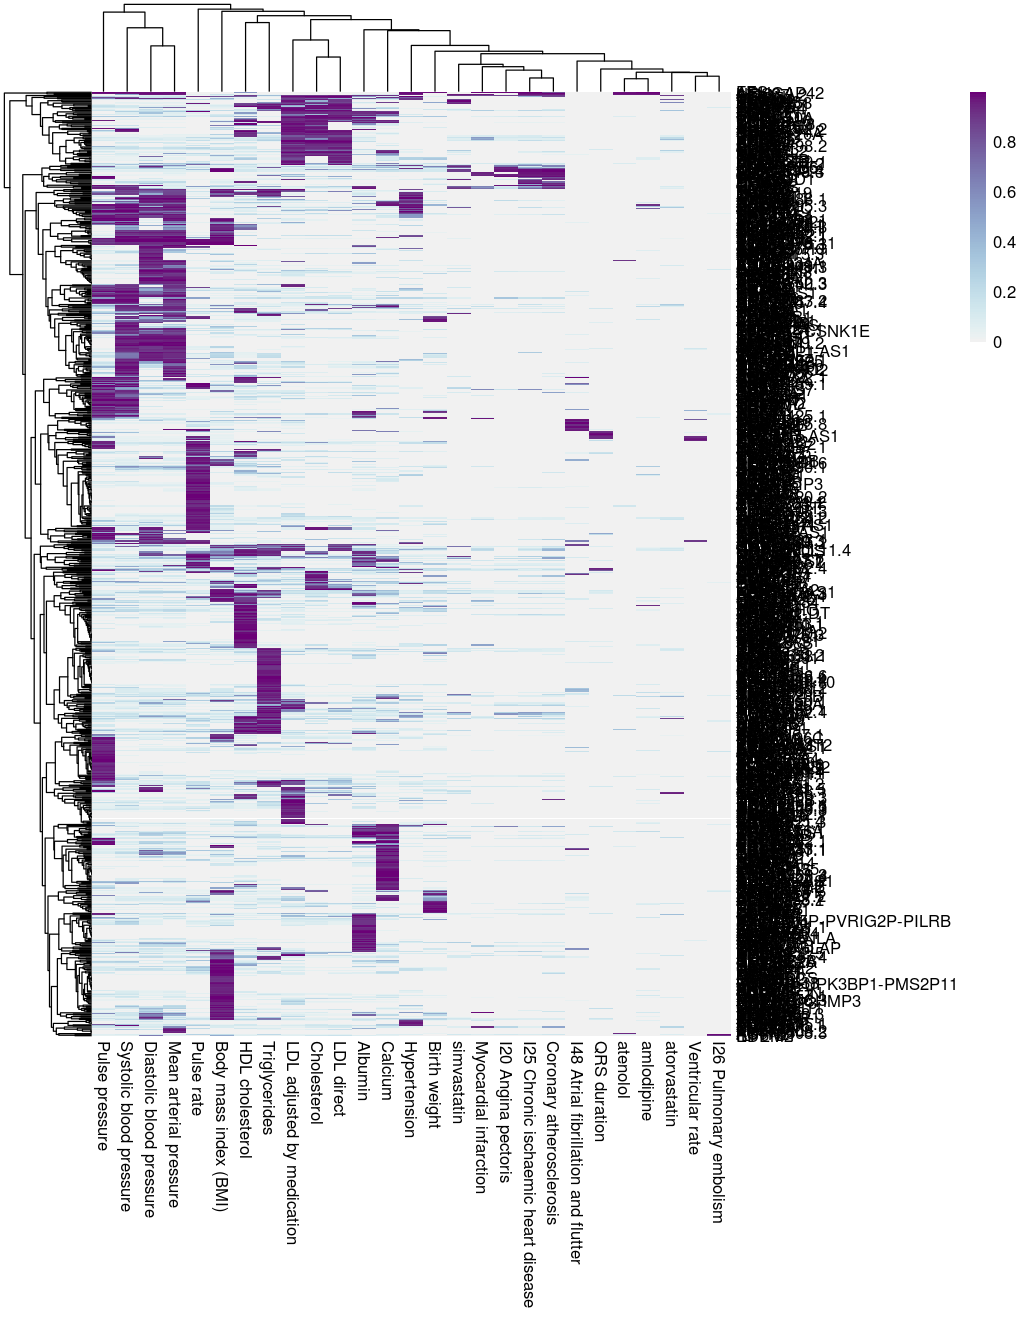

In [40]:
mat2heat           = as.matrix(toplot[ coordinates[ coordinates$transcript_id %in% rownames(toplot) & coordinates$phenotype == "rna", "transcript_id"],])
colnames(mat2heat) = manifest[gwas_toplot, "name"]
rownames(mat2heat) = coordinates[ coordinates$transcript_id %in% rownames(toplot) & coordinates$phenotype == "rna", "gene_name"]

options(repr.plot.width = 8.5, repr.plot.height = 11)
pheatmap(mat2heat, color = sequential_hcl(palette = "Purple-Blue", n = 100, rev = TRUE), cluster_rows = TRUE , cluster_cols = TRUE )


# Look at specific associations: systolic vs. diastolic blood pressure

In [81]:
str(qtl2gwas_df)

'data.frame':	132643 obs. of  5 variables:
 $ transcript_id: chr  "atac_chr16_10694578_10696145" "atac_chr16_10710493_10711701" "atac_chr16_11181579_11182375" "atac_chr16_15005533_15007995" ...
 $ gene_name    : chr  "broad_peak_100245" "broad_peak_100248" "broad_peak_100342" "broad_peak_100819" ...
 $ phenotype    : chr  "atac" "atac" "atac" "atac" ...
 $ gwas         : chr  "biomarkers-30600-both_sexes-irnt" "biomarkers-30600-both_sexes-irnt" "biomarkers-30600-both_sexes-irnt" "biomarkers-30600-both_sexes-irnt" ...
 $ PP.H4.abf    : num  0.0283 0.0383 0.0506 0 0 ...


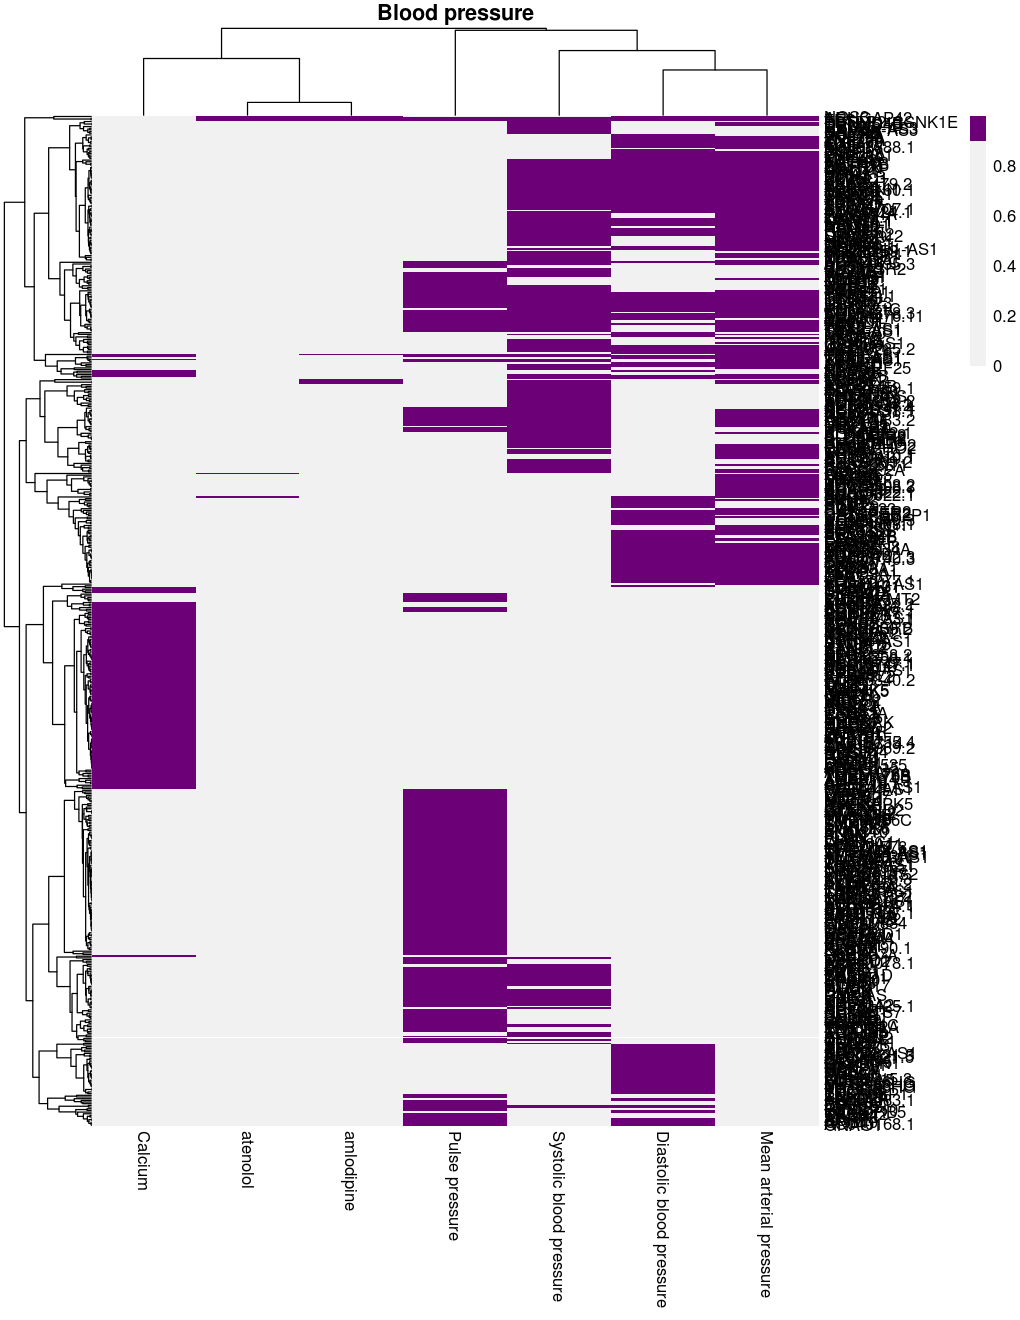

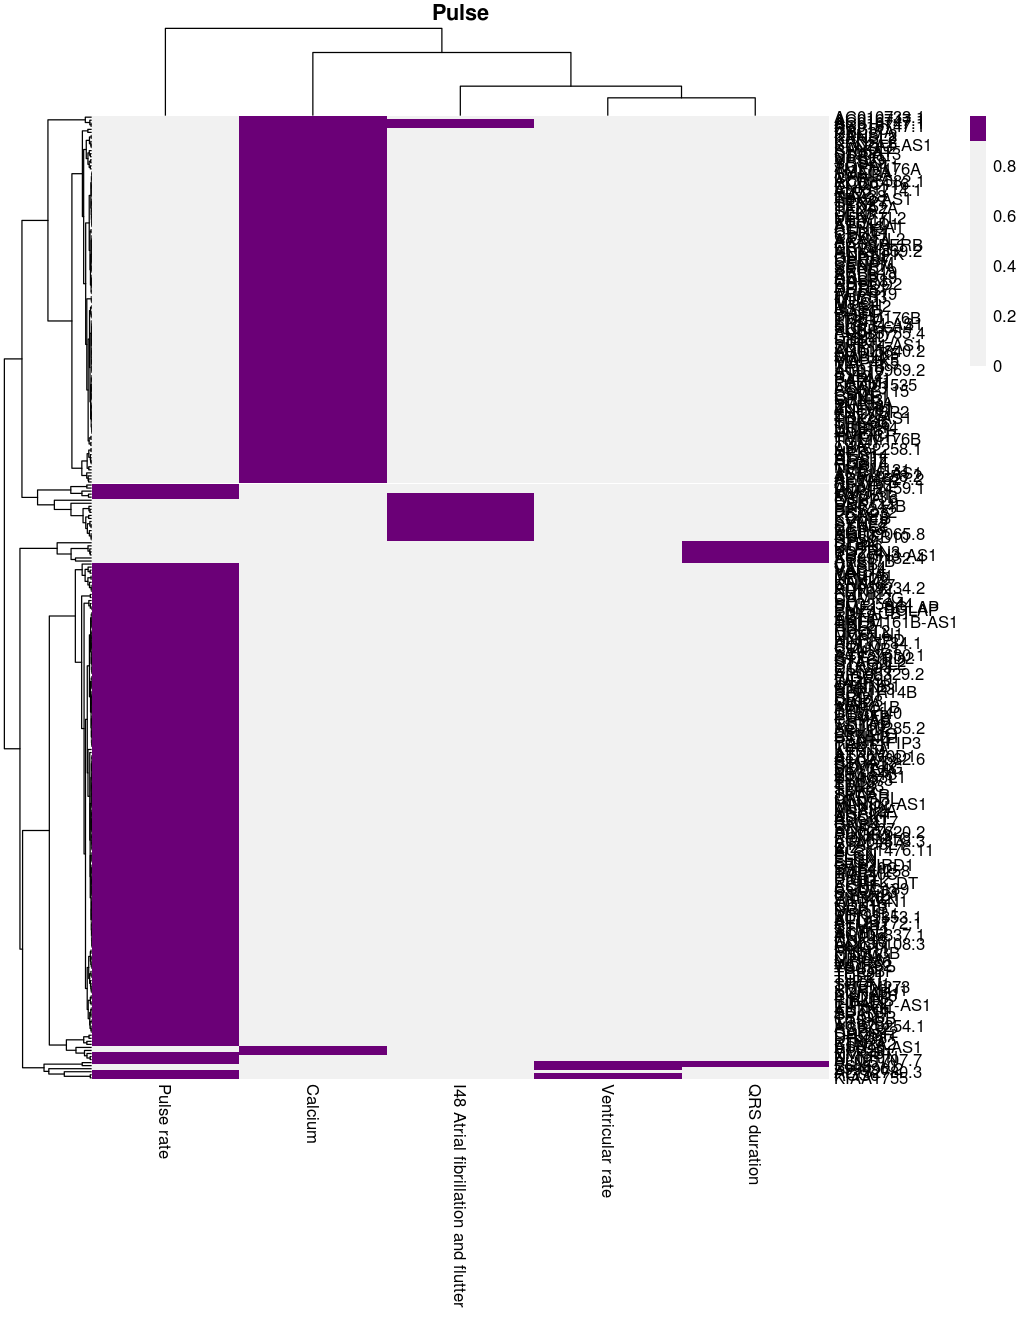

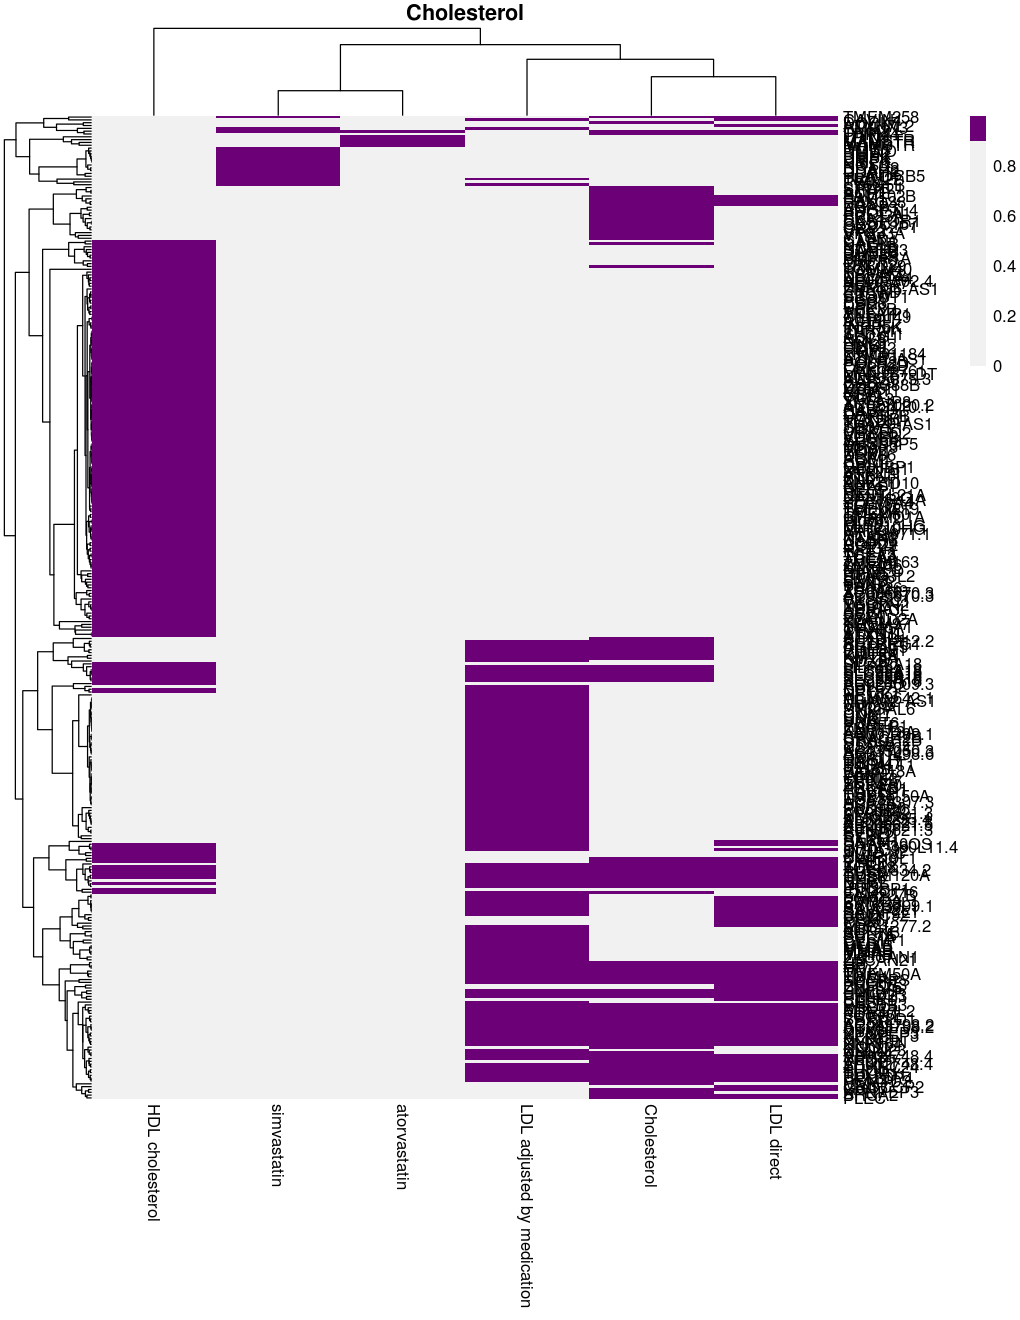

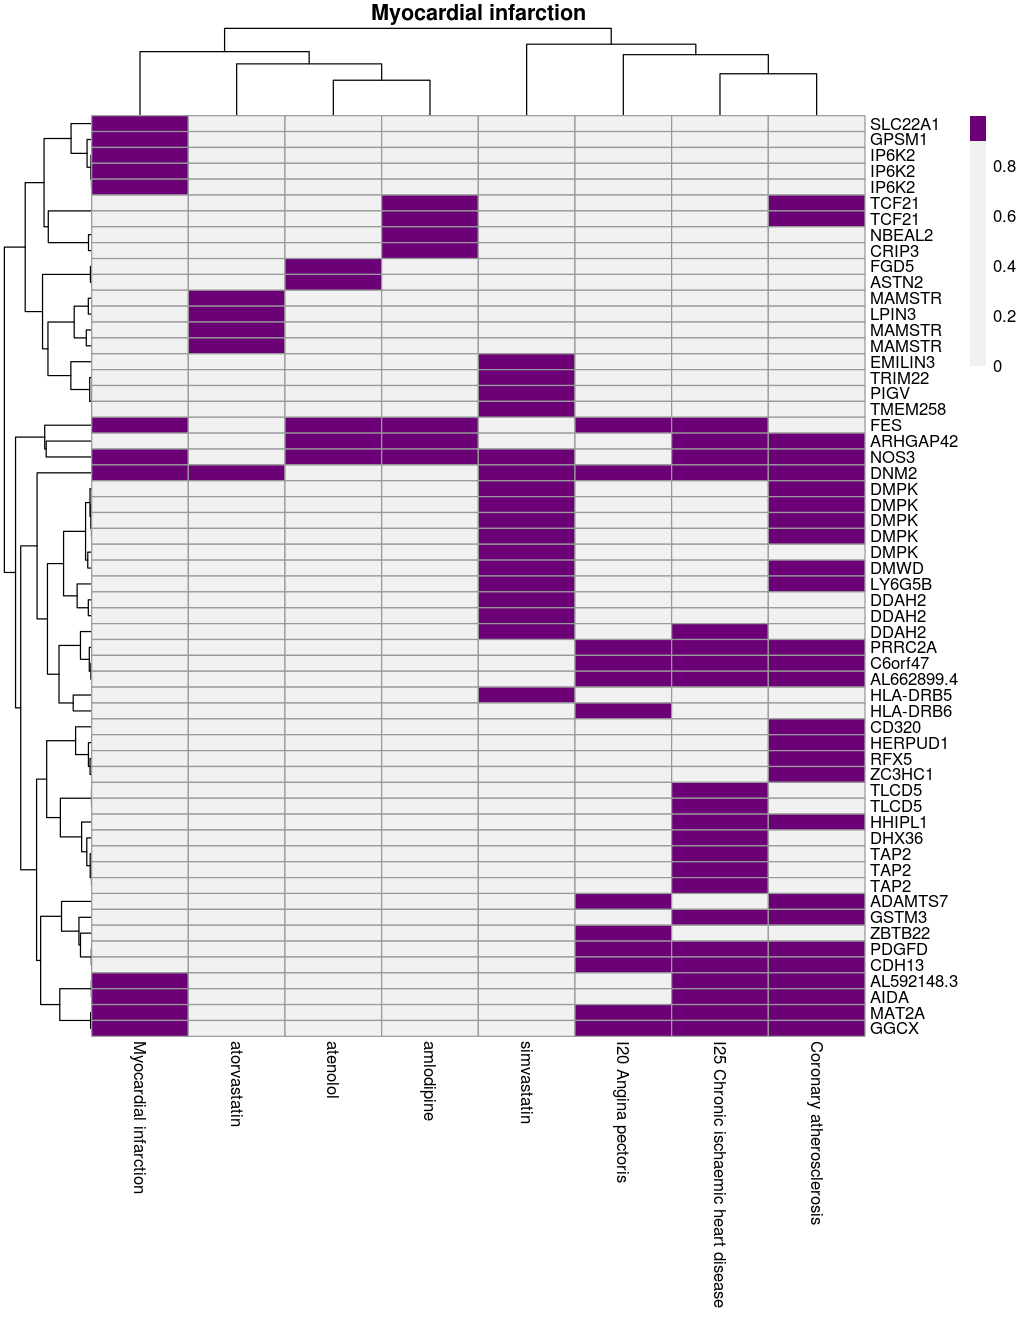

In [82]:
test_traits = function(name, traits, coordinates, qtl2gwas_df, manifest)
{
    qtls_toplot = sort(unique(qtl2gwas_df[ qtl2gwas_df$PP.H4.abf >= 0.9 & qtl2gwas_df$gwas %in% traits & qtl2gwas_df$phenotype %in% c("rna", "isoform"), "transcript_id"]))
    gwas_toplot = traits

    toplot = as.data.frame(matrix(0, nrow = length(qtls_toplot), ncol = length(gwas_toplot), dimnames = list(qtls_toplot, gwas_toplot)))

    for(gwas in colnames(toplot))
    {
        x                             = qtl2gwas_df[qtl2gwas_df$gwas == gwas & qtl2gwas_df$transcript_id %in% qtls_toplot,]
        rownames(x)                   = x$transcript_id
        toplot[x$transcript_id, gwas] = x$PP.H4.abf
    }
    
    #myrows             = coordinates[ coordinates$transcript_id %in% rownames(toplot) & coordinates$phenotype == "rna", "transcript_id"]
    myrows             = coordinates[ coordinates$transcript_id %in% rownames(toplot), "transcript_id"]

    mat2heat           = as.matrix(toplot[ myrows,])
    colnames(mat2heat) = manifest[gwas_toplot, "name"]
    rownames(mat2heat) = coordinates[ myrows, "gene_name"]

    options(repr.plot.width = 8.5, repr.plot.height = 11)
    mycols = sequential_hcl(palette = "Purple-Blue", n = 100, rev = TRUE)
    mycols = c(rep(mycols[[1]], 90), rep(mycols[[100]], 10))
    pheatmap(mat2heat, color = mycols, cluster_rows = TRUE , cluster_cols = TRUE, main = name)
}

traits_pressure = rownames(manifest[manifest$name %in% c("amlodipine", "atenolol", "Calcium") | grepl("pressure", manifest$name) == TRUE,])
traits_pulse    = rownames(manifest[manifest$name %in% c('I48 Atrial fibrillation and flutter', 'Pulse rate', 'QRS duration', 'Ventricular rate', "Calcium"),])
traits_fat      = rownames(manifest[grepl("holesterol", manifest$name) == TRUE | grepl("LDL", manifest$name) == TRUE | manifest$name %in% c("atorvastatin", "simvastatin"),])
traits_mi       = rownames(manifest[manifest$name %in% c('I25 Chronic ischaemic heart disease', 'Coronary atherosclerosis', 'I20 Angina pectoris', 'Myocardial infarction', 'amlodipine', "atenolol", "atorvastatin", "simvastatin"),])

test_traits("Blood pressure"       , traits_pressure, coordinates, qtl2gwas_df, manifest)
test_traits("Pulse"                , traits_pulse   , coordinates, qtl2gwas_df, manifest)
test_traits("Cholesterol"          , traits_fat     , coordinates, qtl2gwas_df, manifest)
test_traits("Myocardial infarction", traits_mi      , coordinates, qtl2gwas_df, manifest)



In [77]:
x = merge(qtl2gwas_df[ qtl2gwas_df$gene_name == "DMPK",], manifest[,c("id", "name")], by.x = "gwas", by.y = "id")
unique(x[x$PP.H4.abf >= 0.9, "name"])

x[order(x$PP.H4.abf, decreasing = TRUE),]




[1] "Albumin"                  "simvastatin"             
[3] "Pulse pressure"           "Systolic blood pressure" 
[5] "Coronary atherosclerosis"

,gwas,transcript_id,gene_name,phenotype,PP.H4.abf,name
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
4,biomarkers-30600-both_sexes-irnt,ENST00000618091.4_5,DMPK,isoform,0.9880607,Albumin
3,biomarkers-30600-both_sexes-irnt,ENST00000596686.5_2,DMPK,isoform,0.9876362,Albumin
1,biomarkers-30600-both_sexes-irnt,ENST00000291270.9_3,DMPK,isoform,0.9857996,Albumin
5,biomarkers-30600-both_sexes-irnt,ENST00000674226.1_1,DMPK,isoform,0.9843081,Albumin
2,biomarkers-30600-both_sexes-irnt,ENST00000354227.9_5,DMPK,isoform,0.9740971,Albumin
74,continuous-PP-both_sexes-combined_medadj_irnt,ENST00000354227.9_5,DMPK,isoform,0.9715133,Pulse pressure
80,continuous-SBP-both_sexes-combined_medadj_irnt,ENST00000354227.9_5,DMPK,isoform,0.9672775,Systolic blood pressure
73,continuous-PP-both_sexes-combined_medadj_irnt,ENST00000291270.9_3,DMPK,isoform,0.9664577,Pulse pressure
75,continuous-PP-both_sexes-combined_medadj_irnt,ENST00000596686.5_2,DMPK,isoform,0.9640430,Pulse pressure


In [48]:
sort(manifest$name)

[1] "Albumin"                             "amlodipine"                         
 [3] "atenolol"                            "atorvastatin"                       
 [5] "Birth weight"                        "Body mass index (BMI)"              
 [7] "Calcium"                             "Cholesterol"                        
 [9] "Coronary atherosclerosis"            "Diastolic blood pressure"           
[11] "HDL cholesterol"                     "Hypertension"                       
[13] "I20 Angina pectoris"                 "I25 Chronic ischaemic heart disease"
[15] "I26 Pulmonary embolism"              "I48 Atrial fibrillation and flutter"
[17] "LDL adjusted by medication"          "LDL direct"                         
[19] "Mean arterial pressure"              "Myocardial infarction"              
[21] "Pulse pressure"                      "Pulse rate"                         
[23] "QRS duration"                        "simvastatin"                        
[25] "Systolic blood pressure"             "Triglycerides"                      
[27] "Ventricular rate"

In [42]:
str(qtl2gwas_df)
str(toplot)

'data.frame':	132643 obs. of  5 variables:
 $ transcript_id: chr  "atac_chr16_10694578_10696145" "atac_chr16_10710493_10711701" "atac_chr16_11181579_11182375" "atac_chr16_15005533_15007995" ...
 $ gene_name    : chr  "broad_peak_100245" "broad_peak_100248" "broad_peak_100342" "broad_peak_100819" ...
 $ phenotype    : chr  "atac" "atac" "atac" "atac" ...
 $ gwas         : chr  "biomarkers-30600-both_sexes-irnt" "biomarkers-30600-both_sexes-irnt" "biomarkers-30600-both_sexes-irnt" "biomarkers-30600-both_sexes-irnt" ...
 $ PP.H4.abf    : num  0.0283 0.0383 0.0506 0 0 ...
'data.frame':	1988 obs. of  27 variables:
 $ biomarkers-30600-both_sexes-irnt              : num  0 0.045 0 0.0461 0.0899 ...
 $ biomarkers-30680-both_sexes-irnt              : num  0 0.0744 0 0.0329 0.1406 ...
 $ biomarkers-30690-both_sexes-irnt              : num  0.999 0.0886 0 0 0 ...
 $ biomarkers-30760-both_sexes-irnt              : num  0 0.2071 0 0.0947 0.0424 ...
 $ biomarkers-30780-both_sexes-irnt              :

In [58]:
str(manifest)

'data.frame':	27 obs. of  42 variables:
 $ trait_type                    : chr  "biomarkers" "biomarkers" "biomarkers" "biomarkers" ...
 $ phenocode                     : chr  "30600" "30680" "30690" "30760" ...
 $ pheno_sex                     : chr  "both_sexes" "both_sexes" "both_sexes" "both_sexes" ...
 $ coding                        : int  NA NA NA NA NA NA 1140861958 1140866738 1140879802 1141146234 ...
 $ modifier                      : chr  "irnt" "irnt" "irnt" "irnt" ...
 $ description                   : chr  "Albumin" "Calcium" "Cholesterol" "HDL cholesterol" ...
 $ description_more              : chr  "" "" "" "" ...
 $ coding_description            : chr  "" "" "" "" ...
 $ category                      : chr  "Biological samples > Assay results > Blood assays > Blood biochemistry" "Biological samples > Assay results > Blood assays > Blood biochemistry" "Biological samples > Assay results > Blood assays > Blood biochemistry" "Biological samples > Assay results > Blood ass